In [32]:
from enum import Enum
from random import random

import numpy as np

# Monte Carlo simulation

# Problem:
# knowing the distribution of traffic during a Black Swan Event, find maximum ColdStart or other strategy to fit the growth

# assumptions
# one we model one function
# we assume that ExecutionEnvironment will be fully retained during the test (so second execution has war start)
# we ignore cross AZ load balancing
# we have not Provisioned Concurrency
# we have no quota on ExecutionEnvironments

# input: https://aws.amazon.com/blogs/compute/operating-lambda-performance-optimization-part-1/


tick_duration_in_seconds = 0.01
second_duration_in_ticks = 1/tick_duration_in_seconds
worker_coldstart_s = 2
worker_coldstart_ticks = int(worker_coldstart_s/tick_duration_in_seconds)

request_processing_s = 0.5
request_processing_ticks = int(request_processing_s/tick_duration_in_seconds)

execution_environment_quota = 1000


metrics = {}


def record_metric(namespace, value):
    # print(metrics)
    # print(clock.tick)
    if namespace not in metrics:
        metrics[namespace] = []

    namespace_values = metrics[namespace]

    if clock.tick >= len(namespace_values):
        # print("Extending")
        # print(len(namespace_values))
        namespace_values.extend([[]]*(clock.tick - len(namespace_values) + 1))
        # print(len(namespace_values))
        # namespace_values.append([])

    namespace_values[clock.tick].append(value)


def metric_percentile(namespace, percentile, tick):
    if namespace not in metrics:
        return None
    namespace_values = metrics[namespace]
    if len(namespace_values) < tick:
        return None

    values = metrics[namespace][tick]
    return np.percentile(values, percentile)


class VirtualClock:
    tick = 0

    @staticmethod
    def seconds_to_ticks(seconds):
        return seconds/tick_duration_in_seconds

    @staticmethod
    def ticks_to_seconds(ticks):
        return ticks*tick_duration_in_seconds

    def step(self):
        self.tick += 1
        # print(f"tick: {self.tick}", end=", ")

    def now(self):
        return self.tick


clock = VirtualClock()


class Request:
    created_on = None
    execution_start = None
    return_start = None

    def __init__(self):
        self.created_on = clock.tick

    def age(self):
        return clock.tick - self.created_on


class Queue:
    queue = []

    def __init__(self):
        pass

    def insert(self, request:Request):
        self.queue.append(request)

    def consume(self) -> Request:
        return self.queue.pop(0)

    def is_empty(self) -> bool:
        return len(self.queue) == 0

    def step(self):
        ages = [*map(lambda x: x.age(), self.queue)]
        if len(ages) > 0:
            max_age = max(ages)
            # print(f"count: {len(self.queue)}, max age:{max_age}")
        else:
            pass
            # print(f"count: {len(self.queue)}")


class ExecutionEnvironmentState(Enum):
    cold_start = 1
    idle = 2
    executing = 3
    #tombstone = 4


class ExecutionEnvironment:
    _state: ExecutionEnvironmentState = None
    coldstart_ticks_left = None
    created_on = None
    request = None
    executed_on = None
    execution_ticks_left = None

    def __init__(self):
        self._state = ExecutionEnvironmentState.cold_start
        self.created_on = clock.tick
        self.coldstart_ticks_left = worker_coldstart_ticks

    def handle(self, request: Request):
        assert self._state != ExecutionEnvironmentState.executing
        assert self.request is None
        self.request = request

    def step(self):
        if self._state == ExecutionEnvironmentState.cold_start:
            self.coldstart_ticks_left -= 1
            if self.coldstart_ticks_left <= 0:
                self._state = ExecutionEnvironmentState.idle
            return  # we are leaving as we've spent our tick

        if self._state == ExecutionEnvironmentState.idle and self.request is not None:
            self._state = ExecutionEnvironmentState.executing
            self.executed_on = clock.now()
            self.execution_ticks_left = request_processing_ticks

        if self._state == ExecutionEnvironmentState.executing:
            self.execution_ticks_left -= 1
            if self.execution_ticks_left <= 0:
                self._state = ExecutionEnvironmentState.idle
                record_metric("execution_time", clock.ticks_to_seconds(clock.now()-self.request.created_on))
                # print(f"Executed request in: {clock.ticks_to_seconds(clock.now()-self.request.created_on)}s")
                self.request = None

    def is_available(self):
        return self._state in [ExecutionEnvironmentState.cold_start, ExecutionEnvironmentState.idle] and self.request == None


class ExecutionEnvironmentPool:
    inbound_queue = None
    workers: [ExecutionEnvironment] = []

    def __init__(self, inbound_queue: Queue):
        self.inbound_queue = inbound_queue

    def step(self):
        while not self.inbound_queue.is_empty():
            r = self.inbound_queue.consume()
            w = self.get_execution_environment()
            if w is None:
                break
            w.handle(r)

        for w in self.workers:
            w.step()

    def get_execution_environment(self):
        """
        provides ExecutionEnvironment
        If nothing is available it will create a new one
        Returns: ExecutionEnvironment
        """
        for w in self.workers:
            if w.is_available():
                return w
        if len(self.workers) < execution_environment_quota:
            w = ExecutionEnvironment()
            self.workers.append(w)
            return w
        else:
            return None


class RequestGenerator:
    queue = None

    def __init__(self, queue: Queue):
        self.queue = queue

    def step(self):
        p = self.distribution_function(clock.now())
        # print(p)
        count = int(p // 1)
        fraction = p % 1
        if random() < fraction:
            count += 1
        # print(f"generated {count}")
        for _ in range(count):
            r = Request()
            self.queue.insert(r)

    def distribution_function(self, tick):
        """

        Args:
            tick:

        Returns: amount of requests to expect in a specific tick

        """
        probability = 2000/second_duration_in_ticks
        # ts_seconds = clock.ticks_to_seconds(tick)
        # probability = ts_seconds*100
        # probability = probability/clock.seconds_to_ticks(1)
        return probability


class Simulation:
    generator = None
    execution_environment_pool = None

    def __init__(self):
        self.inbound_queue = Queue()
        self.generator = RequestGenerator(queue=self.inbound_queue)
        self.execution_environment_pool = ExecutionEnvironmentPool(inbound_queue=self.inbound_queue)

    def step(self):
        if clock.tick % second_duration_in_ticks == 0:
            print(f"time: {clock.ticks_to_seconds(clock.tick)}s")
            print(f"queue: {len(self.inbound_queue.queue)}")
            print(f"execution environments: {len(self.execution_environment_pool.workers)}")
        self.generator.step()
        self.inbound_queue.step()
        self.execution_environment_pool.step()
        if clock.tick % second_duration_in_ticks == 0:
            p95 = metric_percentile("execution_time", 95, clock.tick)
            print(f"execution_time.p95:{p95}")
        clock.step()


def simulation(duration_seconds):
    sim = Simulation()
    for _ in range(int(duration_seconds*second_duration_in_ticks)):
        sim.step()


if __name__ == "__main__":
    simulation(duration_seconds=1*60)


time: 0.0s
queue: 0
execution environments: 0
execution_time.p95:None
time: 1.0s
queue: 0
execution environments: 2000
execution_time.p95:None
time: 2.0s
queue: 1900
execution environments: 2000
execution_time.p95:None
time: 3.0s
queue: 2800
execution environments: 2000
execution_time.p95:2.49
time: 4.0s
queue: 700
execution environments: 2000
execution_time.p95:1.36
time: 5.0s
queue: 0
execution environments: 2000
execution_time.p95:0.49
time: 6.0s
queue: 0
execution environments: 2000
execution_time.p95:0.49
time: 7.0s
queue: 0
execution environments: 2000
execution_time.p95:0.49
time: 8.0s
queue: 0
execution environments: 2000
execution_time.p95:0.49
time: 9.0s
queue: 0
execution environments: 2000
execution_time.p95:0.49
time: 10.0s
queue: 0
execution environments: 2000
execution_time.p95:0.49
time: 11.0s
queue: 0
execution environments: 2000
execution_time.p95:0.49
time: 12.0s
queue: 0
execution environments: 2000
execution_time.p95:0.49
time: 13.0s
queue: 0
execution environments

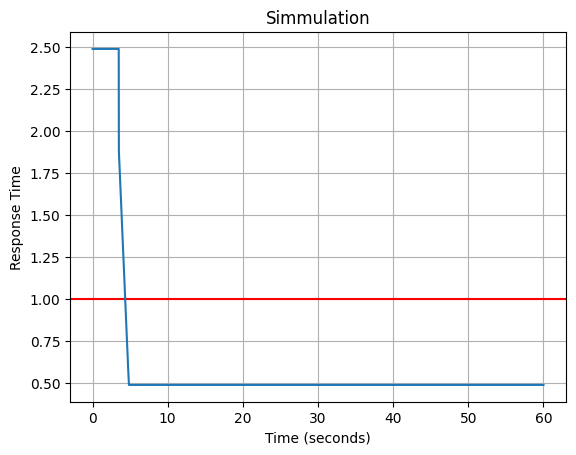

In [44]:
import matplotlib.pyplot as plt
timestamps = np.linspace(0, 60, num=60*100)

values = metrics['execution_time']

# p99 = np.percentile(values, 99, axis=1)
# np.array(values)
p99 = []
for tick in values:
    p99.append(np.percentile(tick, 99))

plt.axhline(y = 1, color = 'red')
plt.plot(timestamps, p99, label='p99')
# plt.scatter(timestamps, p99, color='blue', label='p95')
plt.xlabel('Time (seconds)')
plt.ylabel('Response Time')
plt.title('Simmulation')
plt.grid(True)
plt.show()